In [ ]:
#extraire la colonne litho et la légende (thomas)
#a compléter

In [ ]:
#splitter la colonne litho (laura)
import cv2

dir = './NO_Quad_15/15_2-1/'

image = cv2.imread(dir+'litho_ez.png')

result = image.copy()

# Convert to grayscale and apply Otsu's thresholding
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

cv2.imwrite(dir+"thresh.png", thresh)

# Detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
detect_horizontal = cv2.dilate(detect_horizontal,horizontal_kernel,iterations = 1)
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(result, [c], 0, (36,255,12), 1)

cv2.imwrite(dir+"split.png", result)

# # Find maximum of x and minimum
x_start = 0
x_end = 42
y_top = cnts[0][0][0][1]
y_end = image.shape[0]
cv2.imwrite(dir+str(0)+".png", image[y_top:y_end, x_start:x_end])
for i in range(len(cnts)-1):
    y_end = cnts[i][0][0][1]
    y_top= cnts[i+1][0][0][1]
    cv2.imwrite(dir+str(i+1)+".png", image[y_top:y_end, x_start:x_end])
y_end = cnts[len(cnts)-1][0][0][1]
y_top = 1
if y_end - y_top > 0:
    cv2.imwrite(dir+str(len(cnts))+".png", image[y_top:y_end, x_start:x_end])

In [26]:
#prédire la classe de chaque image (mathis) avec model.h5 entrainé avec un ResNet50
#prédiction de plusieurs images d'une même classe
import os
import numpy as np
import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class_labels = ['limestone', 'marl_limestone', 'marl_marlstone', 'salt', 'sand', 'sand_clay', 'silt']

model = load_model('model.h5')

# Charger toutes les images du dossier test
test_dir = './NO_Quad_15/15_2-1/'

for i in range(0, 15):  # On suppose qu'il y a 10 images
    # Ouvrir l'image
    image_files = glob.glob(os.path.join(test_dir, f"{i}.png"))

    for image_file in image_files:
        img = load_img(image_file, target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)

        # Trouver la classe prédite et afficher le résultat
        class_idx = np.argmax(preds[0])
        predicted_label = class_labels[class_idx]
        print("Classe prédite :", predicted_label)

1/1 [==============================] - 1s 1s/step
Classe prédite : silt
1/1 [==============================] - 0s 151ms/step
Classe prédite : silt
1/1 [==============================] - 0s 138ms/step
Classe prédite : silt
1/1 [==============================] - 0s 137ms/step
Classe prédite : sand_clay
1/1 [==============================] - 0s 139ms/step
Classe prédite : sand_clay
1/1 [==============================] - 0s 136ms/step
Classe prédite : silt
1/1 [==============================] - 0s 158ms/step
Classe prédite : silt
1/1 [==============================] - 0s 141ms/step
Classe prédite : silt
1/1 [==============================] - 0s 149ms/step
Classe prédite : sand_clay
1/1 [==============================] - 0s 198ms/step
Classe prédite : sand_clay
1/1 [==============================] - 0s 208ms/step
Classe prédite : silt
1/1 [==============================] - 0s 167ms/step
Classe prédite : sand_clay
1/1 [==============================] - 0s 227ms/step
Classe prédite : silt
1/1

In [32]:
#calcul de la hauteur relative de tous les png
import openpyxl
from PIL import Image
from openpyxl.chart import PieChart, Reference

# Ouvrir les images et stocker les hauteurs relatives pour chaque matériau
heights = {m: [] for m in class_labels}

for i in range(0, 15):  # On suppose qu'il y a 10 images
    # Ouvrir l'image
    img = Image.open(f"./NO_Quad_15/15_2-1/{i}.png")

    # Calculer la hauteur (en pixels)
    # pas besoin de la largeur qui sera identique
    height = img.height
    valeur_relative = height / 100

    # Ouvrir l'image
    image_files = glob.glob(os.path.join(test_dir, f"{i}.png"))

    for image_file in image_files:
        img = load_img(image_file, target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)

        # Trouver la classe prédite et afficher le résultat
        class_idx = np.argmax(preds[0])
        predicted_label = class_labels[class_idx]

        # Ajouter la hauteur relative à la liste correspondant au matériau aléatoire choisi
        class_label = predicted_label
        #print(class_label)
        heights[class_label].append(valeur_relative)
    

1/1 [==============================] - 0s 169ms/step


In [33]:
#création du tableur excel et remplissage
# Créer le tableur Excel
wb = openpyxl.Workbook()
ws = wb.active

# Ajouter les hauteurs relatives pour chaque matériau dans le tableur
for i, m in enumerate(class_labels):
    # Ajouter le nom du matériau dans la première colonne
    ws.cell(row=i+2, column=1, value=m)

    # Ajouter les hauteurs relatives dans les colonnes suivantes
    for j, h in enumerate(heights[m]):
        ws.cell(row=i+2, column=j+2, value=h)

# # Ajouter la ligne des totaux
for j in range(2, 7):
    sub_sum = sum(ws.cell(row=i, column=j).value or 0 for i in range(2, len(class_labels)+2))
    ws.cell(row=len(class_labels)+2, column=j, value=sub_sum)

# Ajouter la colonne des totaux
for i in range(2, len(class_labels)+3):
    sub_sum = sum(ws.cell(row=i, column=j).value or 0 for j in range(2, 7))
    ws.cell(row=i, column=7, value=sub_sum)

# Ajouter la colonne des pourcentages
for i in range(2, len(class_labels)+2):
    percent = sum(ws.cell(row=i, column=j).value or 0 for j in range(2, 7)) / ws.cell(row=len(class_labels)+2, column=7).value
    ws.cell(row=i, column=8, value=percent).number_format = '0.00%'

# Enregistrer le tableur Excel
#wb.save("resultats_tmp.xlsx")

In [34]:
#génération du graphique camembert
# Créer le graphique camembert
chart = PieChart()
chart.title = "Pourcentage Lithologie"


# Ajouter les données du graphique
labels = Reference(ws, min_col=1, min_row=2, max_row=len(class_labels)+1)
data = Reference(ws, min_col=8, min_row=1, max_row=len(class_labels)+1)
chart.add_data(data, titles_from_data=True)
chart.set_categories(labels)

# Ajouter le graphique au tableur
ws.add_chart(chart, "J2")

# Enregistrer le tableur Excel
wb.save("resultats.xlsx")

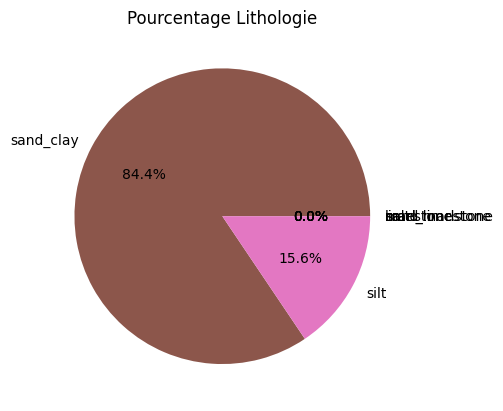

In [36]:
import matplotlib.pyplot as plt
# Générer le graphique camembert
labels = class_labels
sizes = ws['H2':'H8']
sizes = [cell[0].value for cell in sizes]
#colors = ['#FEDC56', '#FDB813', '#F37121', '#D1206B', '#7B1F72']

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Pourcentage Lithologie')
plt.show()